In [1]:
# select the data
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from colmap.scripts.python.read_write_model import read_model, qvec2rotmat
from imageio import imread
import matplotlib.pyplot as plt
import h5py
import deepdish as dd
from time import time

root = '/home/runyi/Data/phototourism/'
seq = 'notre_dame_front_facade'
src = root + '/' + seq
print(f'Done')

Done


In [2]:
# load reconstruction from colmap
cameras, images, points = read_model(path=src + '/dense/sparse', ext='.bin')

print(f'Cameras: {len(cameras)}')
print(f'Images: {len(images)}')
print(f'3D points: {len(points)}')

indices = [i for i in cameras]

Cameras: 3765
Images: 3765
3D points: 488895


Number of (valid) points: 4630
Number of (total) points: 7874


/tmp/ipykernel_217423/3901647830.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imread(src + '/dense/images/' + images[idx].name)


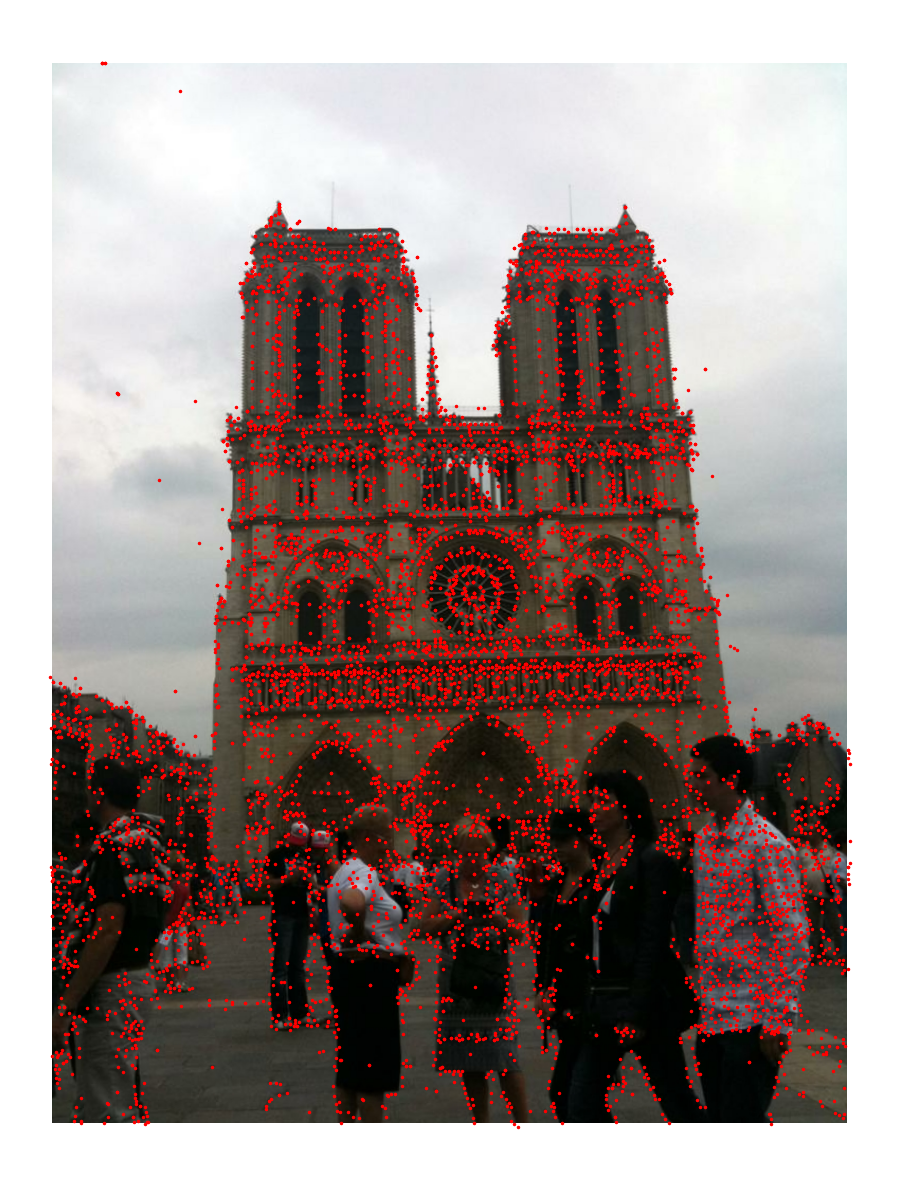

In [3]:
# Retrieve one image, the depth map, and 2D points
def get_image(idx):
    im = imread(src + '/dense/images/' + images[idx].name)

    # reformat data
    q = images[idx].qvec
    R = qvec2rotmat(q)
    T = images[idx].tvec
    p = images[idx].xys
    pars = cameras[idx].params
    K = np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])
    pids = images[idx].point3D_ids
    v = pids >= 0
    print('Number of (valid) points: {}'.format((pids > -1).sum()))
    print('Number of (total) points: {}'.format(v.size))
    

    return {
        'image': im,
        'K': K,
        'q': q,
        'R': R,
        'T': T,
        'xys': p,
        'ids': pids,
        'valid': v}

idx = indices[0]
data = get_image(idx)

# plot the image and the points that match to the 3D model
ms = 3
fig = plt.figure(figsize=(12, 12))
f1 = plt.imshow(data['image'])
plt.plot(data['xys'][:, 0], data['xys'][:, 1], 'r.', markersize=ms)
plt.plot(data['xys'][data['valid'], 0], data['xys'][data['valid'], 1], 'r.', markersize=ms)
plt.axis('off')

fig.tight_layout()
plt.show()

In [4]:
# We can just retrieve all the 3D points
xyz, rgb = [], []
for i in points:
    xyz.append(points[i].xyz)
    rgb.append(points[i].rgb)
xyz = np.array(xyz)
rgb = np.array(rgb)

# you can also retrieve the points that can be found for this image only
cur = []
subset = []
for p in data['ids']:
    if p >= 0:
        cur.append(points[p].xyz)
        subset.append(p)
cur = np.array(cur)

print(xyz.shape)
print(cur.shape)

(488895, 3)
(4630, 3)


(-38.24541317074456, 789.3136045287314, 1001.5, -0.5)

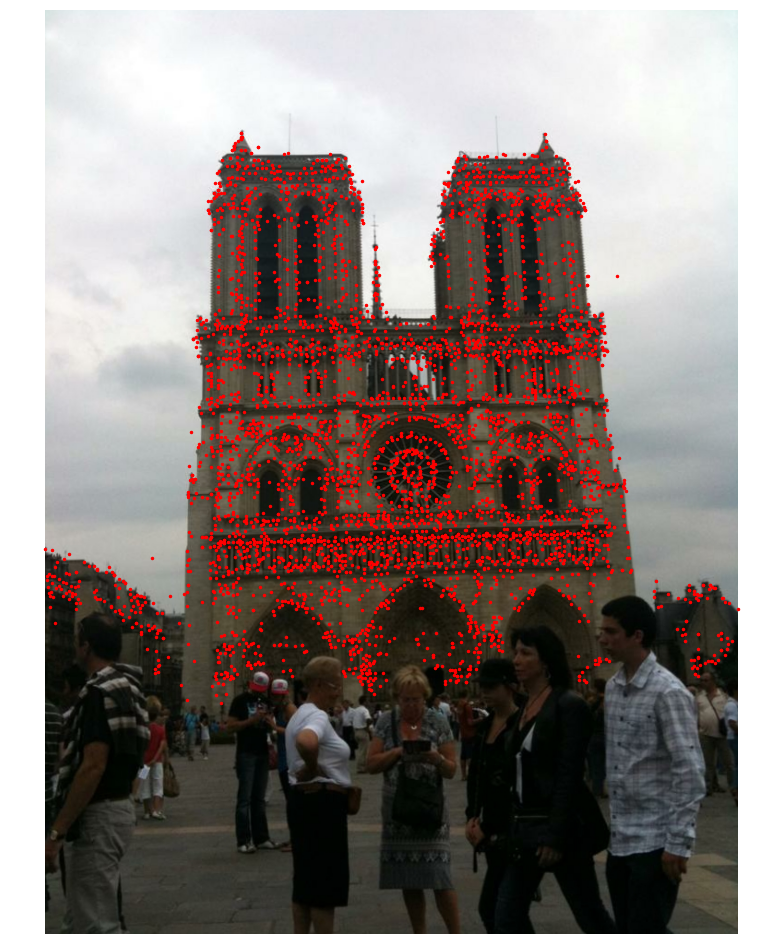

In [5]:
K = data['K']
R = data['R']
T = data['T']

p_proj = np.dot(K, np.dot(R, cur.T) + T[..., None])
p_proj = p_proj / p_proj[2, :]

fig = plt.figure(figsize=(12, 12))
f = plt.imshow(data['image'])
plt.plot(p_proj[0, :], p_proj[1, :], 'r.', markersize=3)
plt.axis('off')

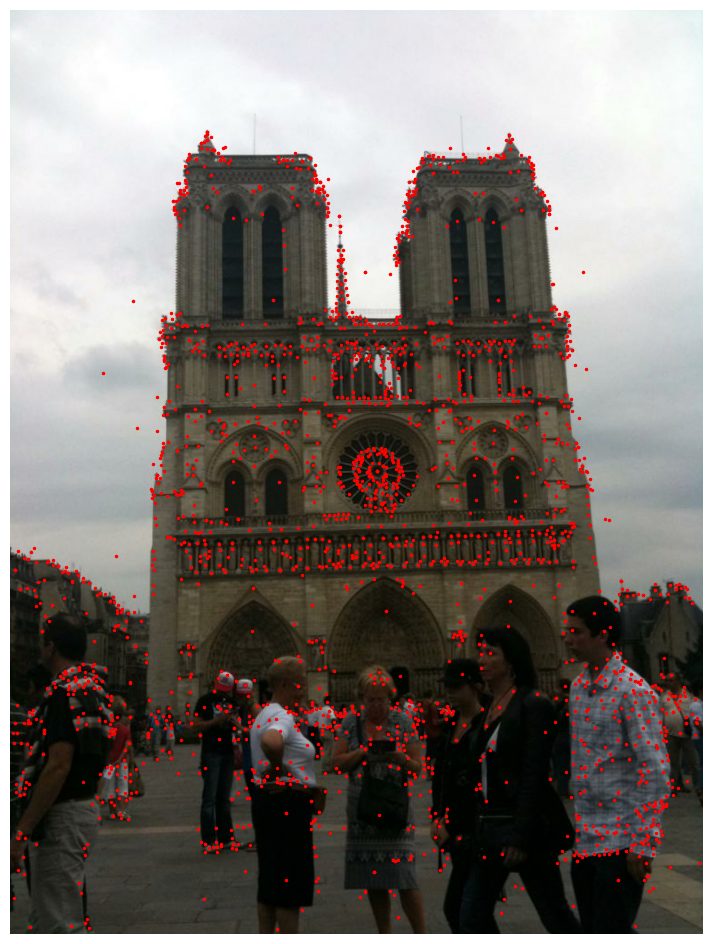

In [6]:
import cv2
sift = cv2.SIFT_create()
kp1, des = sift.detectAndCompute(data['image'], None)
kp = np.array([k.pt for k in kp1])

fig = plt.figure(figsize=(12, 12))
f = plt.imshow(data['image'])
plt.plot(kp[:, 0], kp[:, 1], 'r.', markersize=3)
plt.axis('off')
plt.show()

In [21]:
kp2 = tuple([cv2.KeyPoint(p_proj[0][i], p_proj[1][i], size=3) for i in range(p_proj.shape[1])])

des2 = sift.compute(data['image'], kp1)

In [22]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des, des2[1], k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)

print(len(good_matches))

2633


In [23]:
# Function to estimate essential matrix and recover pose
def estimate_pose(kp1, kp2, matches, K):
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    E, mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, points1, points2, K)
    return R, t

In [35]:
good_matches = sorted(good_matches, key=lambda x: x.distance)
estimate_pose(kp1, kp2, good_matches, data['K'])

(array([[ 8.73795693e-04, -9.93683800e-01, -1.12212928e-01],
        [ 9.98408641e-01, -5.46038919e-03,  5.61281626e-02],
        [-5.63863722e-02, -1.12083401e-01,  9.92097721e-01]]),
 array([[ 0.84569073],
        [-0.04212488],
        [-0.53200817]]))

In [36]:
dir(good_matches[0])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'distance',
 'imgIdx',
 'queryIdx',
 'trainIdx']

In [38]:
points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

In [44]:
sorted(points1, key=lambda x: x[0])

[array([  2.6895044, 783.35956  ], dtype=float32),
 array([  3.5065093, 962.6809   ], dtype=float32),
 array([  3.6481605, 794.6407   ], dtype=float32),
 array([  4.504597, 606.64777 ], dtype=float32),
 array([  4.504597, 606.64777 ], dtype=float32),
 array([  4.504597, 606.64777 ], dtype=float32),
 array([  4.6038384, 772.7353   ], dtype=float32),
 array([  4.6038384, 772.7353   ], dtype=float32),
 array([  6.3685093, 839.0394   ], dtype=float32),
 array([  6.4739223, 847.75854  ], dtype=float32),
 array([  6.6943293, 783.59973  ], dtype=float32),
 array([  6.6943293, 783.59973  ], dtype=float32),
 array([  7.551674, 753.675   ], dtype=float32),
 array([  7.839049, 586.43866 ], dtype=float32),
 array([  7.8440185, 932.02026  ], dtype=float32),
 array([  8.149116, 897.6298  ], dtype=float32),
 array([  8.149116, 897.6298  ], dtype=float32),
 array([  9.9418125, 850.5054   ], dtype=float32),
 array([  9.9418125, 850.5054   ], dtype=float32),
 array([ 10.16824, 626.882  ], dtype=float32)

In [45]:
sorted(points2, key=lambda x: x[0])

[array([ -0.6290942, 583.84186  ], dtype=float32),
 array([  1.8566617, 613.4772   ], dtype=float32),
 array([  2.2540383, 617.7531   ], dtype=float32),
 array([  4.5240707, 610.9588   ], dtype=float32),
 array([  6.128163, 630.5219  ], dtype=float32),
 array([  7.7661686, 620.8948   ], dtype=float32),
 array([  8.378795, 635.648   ], dtype=float32),
 array([ 11.07684, 603.09906], dtype=float32),
 array([ 14.839922, 616.70294 ], dtype=float32),
 array([ 15.0838375, 623.974    ], dtype=float32),
 array([ 17.100668, 627.1186  ], dtype=float32),
 array([ 19.809458, 595.16235 ], dtype=float32),
 array([ 22.273033, 610.42365 ], dtype=float32),
 array([ 25.415445, 611.01526 ], dtype=float32),
 array([ 26.070684, 629.0406  ], dtype=float32),
 array([ 33.572166, 649.4637  ], dtype=float32),
 array([ 35.923973, 623.7778  ], dtype=float32),
 array([ 37.266876, 642.6912  ], dtype=float32),
 array([ 41.94189, 597.725  ], dtype=float32),
 array([ 46.912018, 601.9894  ], dtype=float32),
 array([ 52.

In [49]:
sorted(p_proj.T, key=lambda x: x[0])

[array([ -0.62909418, 583.84186263,   1.        ]),
 array([  1.85666169, 613.47719157,   1.        ]),
 array([  2.25403828, 617.75311457,   1.        ]),
 array([  2.66470532, 625.53605825,   1.        ]),
 array([  4.14253418, 632.2283661 ,   1.        ]),
 array([  4.52407062, 610.95878214,   1.        ]),
 array([  4.61125231, 646.8938961 ,   1.        ]),
 array([  5.39039262, 635.32770757,   1.        ]),
 array([  6.12816263, 630.5219362 ,   1.        ]),
 array([  6.82254833, 613.32987061,   1.        ]),
 array([  7.16110801, 585.17502889,   1.        ]),
 array([  7.76616836, 620.89476397,   1.        ]),
 array([  8.37879435, 635.64803539,   1.        ]),
 array([  9.99321717, 613.75854694,   1.        ]),
 array([ 10.69776664, 664.05106718,   1.        ]),
 array([ 11.07684064, 603.09906944,   1.        ]),
 array([ 11.50960907, 626.55789978,   1.        ]),
 array([ 12.25630349, 598.11676872,   1.        ]),
 array([ 14.83992177, 616.70291232,   1.        ]),
 array([ 15.

In [53]:
sorted(kp, key=lambda x: x[0])

[array([  2.68950438, 783.35955811]),
 array([  3.5065093, 962.6809082]),
 array([  3.64816046, 794.64068604]),
 array([  4.50459719, 606.64776611]),
 array([  4.50459719, 606.64776611]),
 array([  4.50459719, 606.64776611]),
 array([  4.60383844, 772.73529053]),
 array([  4.60383844, 772.73529053]),
 array([  6.36850929, 839.03942871]),
 array([  6.47392225, 847.75854492]),
 array([  6.69432926, 783.59973145]),
 array([  6.69432926, 783.59973145]),
 array([  7.55167389, 753.67498779]),
 array([  7.83904886, 586.43865967]),
 array([  7.84401846, 932.02026367]),
 array([  8.14911556, 897.62982178]),
 array([  8.14911556, 897.62982178]),
 array([  9.94181252, 850.50537109]),
 array([  9.94181252, 850.50537109]),
 array([ 10.16823959, 626.88201904]),
 array([ 10.16823959, 626.88201904]),
 array([ 10.39949989, 843.14782715]),
 array([ 10.64147186, 891.6237793 ]),
 array([ 10.64147186, 891.6237793 ]),
 array([ 11.20299244, 794.74255371]),
 array([ 11.20299244, 794.74255371]),
 array([ 11.56